# 循环神经网络
从零实现循环神经网络，并了解其内部的细节问题

In [1]:
%matplotlib inline
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
from matplotlib_inline import backend_inline
from torch import nn
from torch.nn import functional as F
from typing import Callable, Iterator
from tqdm.notebook import tqdm
import funcs

backend_inline.set_matplotlib_formats('svg')



隐状态中 $ X_{t}  W_{xh} + H_{t-1}  W_{hh} $的计算，相当于$ X_{t} $与$ H_{t-1} $在列的拼接和$ W_{xh}$与$W_{hh} $在行拼接的乘法。

In [2]:
X, W_xh = torch.normal(0,1,(3,1)), torch.normal(0,1,(1,4))
H, W_hh = torch.normal(0,1,(3,4)), torch.normal(0,1,(4,4))
print(X @ W_xh + H @ W_hh)
print(torch.cat((X, H), dim=1) @ torch.cat((W_xh, W_hh), dim=0))

tensor([[-0.7596, -3.7528, -3.7728,  2.3338],
        [-3.2680,  2.6225, -0.8343, -0.1375],
        [ 0.9074, -4.5047, -2.5226,  1.1065]])
tensor([[-0.7596, -3.7528, -3.7728,  2.3338],
        [-3.2680,  2.6225, -0.8343, -0.1375],
        [ 0.9074, -4.5047, -2.5226,  1.1065]])


数据形状 $X$ 为 (小批量, 时间序列) 
- 将其做词向量编码时进行转置处理, 将时间序列作为第一轴, 方便按时间访问数据
- 这里使用 $OneHot$ 方法做词向量编码

In [3]:
X = torch.arange(0,15).reshape((3, 5))
X_hot = F.one_hot(X.T, 28)
print(X.shape, X_hot.shape)
del X, X_hot

torch.Size([3, 5]) torch.Size([5, 3, 28])


## 开始进行循环神经网络的实现, 定义超参数: 

In [4]:
batch_size, num_steps = 32, 35
train_iter, vocab = funcs.load_data_time_machine(
    batch_size, num_steps, token_type="char")
train_iter, vocab

(<TimeMachineLoader with 10000 corpus: "t", "h", "e", " ", "t", ...>,
 <Vocab with 28 tokens: "<unk>", " ", "e", "t", "a", ...>)

## 初始化循环神经网络的模型参数

In [5]:
loss_ = Callable[[torch.Tensor,torch.Tensor], torch.Tensor]
param_ = Callable[[int, int, str], list]
def get_rnn_params(vocab_size:int, num_hiddens:int, device:str="cuda:0"):
    num_inputs = num_outputs = vocab_size  # 针对one-hot编码，所以维度与字典长度相等
    normal = lambda shape: torch.randn(size=shape, device=device) * 0.01
    # 隐藏层的参数
    # [time_steps, b, embedding] -> [time_steps, b, h]
    W_xh = normal((num_inputs, num_hiddens))
    # [b, h] -> [h, h]
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q  = torch.zeros(num_outputs, device=device)
    # 赋予梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

state_ = Callable[[int, int, str], torch.Tensor]
def init_rnn_state(batch_size:int, num_hiddens:int, device:str):
    """初始化隐藏状态"""
    return (torch.zeros((batch_size, num_hiddens), device=device))


$RNN$的输出由隐状态得出:  
- $H_{t} = X_{t}  W_{xh} + H_{t-1}  W_{hh} \\ O_{t} = H_{t} W_{hq} + b_{q}$

In [6]:
forward_ = Callable[[torch.Tensor, torch.Tensor, list], tuple]
def rnn_forward(inputs:torch.Tensor, state:torch.Tensor, params:list):
    """在一个时间步内计算隐藏状态和输出"""
    W_xh, W_hh, b_h, W_hq, b_q = params
    out_puts = []
    # inputs : [time_steps, b, embedding]
    for X in inputs:
        state = torch.tanh(X @ W_xh + state @ W_hh + b_h)
        Y = state @ W_hq + b_q
        out_puts.append(Y)
    return torch.cat(out_puts, dim=0), state


class RNN(nn.Module):
    """循环神经网络的简单实现"""
    def __init__(self, vocab_size:int, num_hiddens:int, device:str, 
                    get_params:param_, init_state:state_, 
                    forward_fn:forward_) -> None:
        super().__init__()
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
    
    def forward(self, x:torch.Tensor, state:torch.Tensor):
        x = F.one_hot(x.T, self.vocab_size).to(torch.float32)
        return self.forward_fn(x, state, self.params)
        
    def begin_state(self, batch_size:int, device:str):
        return self.init_state(batch_size, self.num_hiddens, device)
    
    def parameters(self, recurse: bool = True):
        for param in self.params:
            yield param

    def __repr__(self) -> str:
        out = f"<RNN_Module with {self.num_hiddens} hiddens>"
        return out


检查模型输出形状是否正确

In [23]:
num_hiddens = 512
device = "cuda:0"
rnn = RNN(len(vocab), num_hiddens, device, get_rnn_params, init_rnn_state, rnn_forward)
x, y = next(iter(train_iter))
state = rnn.begin_state(train_iter.batch_size, device)
Y, new_state = rnn(torch.tensor(x).to(device), state)
Y.shape, new_state[0].shape

(torch.Size([32, 35]), torch.Size([1120, 28]), torch.Size([512]))

## 预测
- 定义一个预测函数，用来生成 `prefix` 后的新字符。其中的 `prefix` 是一个用户提供的包含多个字符的字符串。 在循环遍历 `prefix` 中的开始字符时， 不断地将隐状态传递到下一个时间步，但是不生成任何输出。 这被称为预热（warm-up）期， 因为在此期间模型会自我更新（例如，更新隐状态）， 但不会进行预测。 预热期结束后，隐状态的值通常比刚开始的初始值更适合预测， 从而预测字符并输出它们。

In [8]:
def predict(prefix, num_preds:int, net:RNN, vocab:funcs.Vocab, device:str):
    state     = net.begin_state(batch_size=1, device=device)
    outputs   = [vocab[prefix[0]]]
    # 每次以输出序列的最后一个字符作为输入
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1,1))
    # 这个阶段作为预热阶段
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    # 这个阶段为预测阶段
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=-1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])


In [9]:
predict("time machine and ", 20, rnn, vocab, "cuda:0")

'time machine and vkwcmiiuiiuiiuiiuiiu'

### 梯度裁剪
为了防止梯度过大，在链式传播的过程中产生爆炸，对梯度的进行裁剪：

$ g \gets min(1, \frac{\theta}{||g||}) \cdot g $

In [10]:
def grad_clipping(net:nn.Module, theta:float):
    """梯度裁剪"""
    params = [p for p in net.parameters() if p.requires_grad]
    # 计算 ||g||
    norm = torch.sqrt( sum(torch.sum(p.grad ** 2) for p in params) )
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

以下代码演示了梯度裁剪的实际效果。线性函数中的偏置 $w$ 的梯度被裁剪到了 $\theta$ 范围内

In [317]:
l1 = nn.Linear(1,1,False)
loss = (l1(torch.tensor([1.])) ** 2).sum()
loss.backward()
print(l1.weight.grad)
grad_clipping(l1, 1.)
print(l1.weight.grad)

tensor([[1.8032]])
tensor([[1.0000]])


## 训练
循环神经网络的训练与多层感知机存在部分差异:
1. 序列数据的不同采样方法会导致隐状态初始化的差异
2. 需要在更新模型前裁剪梯度，保证某点处发生的梯度爆炸不会导致模型发散
3. 用困惑度评价模型，确保不同长度的序列仍然具有可比性


In [11]:
class Timer():
    """简易计时器"""
    def __init__(self):
        self.start_time = time.time()
    def stop(self)-> float:
        return time.time() - self.start_time

def train_rnn_one_epoch(net:RNN, train_iter:funcs.SeqDataLoaderTimeMachine, loss:loss_, opt:torch.optim.Optimizer, device:str, use_random_iter:bool):
    """返回结果:困惑度, 训练速度 (词元/秒) """
    state = None
    loss_count, num_tokens = 0, 0
    timer = Timer()
    for x, y in train_iter:
        # 转置后展平，标签数据按照时序排列
        y = torch.tensor(y).T.reshape(-1)
        x, y = torch.tensor(x).to(device), y.to(device)
        # 需要初始化隐变量的情况
        if state is None or use_random_iter:
            # 如果使用随机抽样方法，则每个minibatch都重新初始化state
            state = net.begin_state(x.shape[0], device)
        else:
            state = state.detach()
        y_hat, state = net(x, state)
        l = loss(y_hat, y.to(torch.long)).mean()
        # 更新梯度
        opt.zero_grad()
        l.backward()
        grad_clipping(net, 1.)
        opt.step()
        # .numel() 返回张量中的所有参数数量
        loss_count += l * y.numel()
        num_tokens += y.numel()
    with torch.no_grad():
        return torch.exp(loss_count / num_tokens), num_tokens / timer.stop()
        

### 使用随机抽样训练

  0%|          | 0/500 [00:00<?, ?it/s]

困惑度[1.48], 速度[133476.0 词元/秒], 设备[cuda:1]
time traveller s returnxvi after the storyepilogueiintroductiont
traveller but now you begin to see theobject of my investig


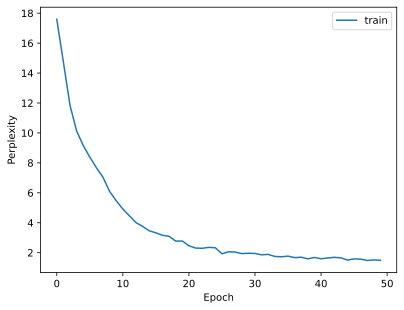

In [16]:
num_epochs, lr = 500, 5e-4
device = "cuda:1"
loss = nn.CrossEntropyLoss()

# 初始化网络
rnn = RNN(len(vocab), num_hiddens, device, get_rnn_params, init_rnn_state, rnn_forward)
# 定义优化器
opt = torch.optim.Adam(rnn.parameters(), lr=lr)
# 文本生成函数
pred_fn = lambda prefix: predict(prefix, 50, rnn, vocab, device)

rnn.train()
ppl_ = []

for epo in tqdm(range(num_epochs)):
    ppl, speed = train_rnn_one_epoch(
        rnn, train_iter, loss, opt, device, True)
    if (epo + 1) % 10 == 0:
        # print(f"epo:{epo+1}\t ppl:{ppl:.1f}\t")
        # print(pred_fn("time traveller"))
        ppl_.append(float(ppl))

print(f'困惑度[{ppl:.2f}], 速度[{speed:.1f} 词元/秒], 设备[{str(device)}]')
print(pred_fn('time traveller'))
print(pred_fn('traveller'))

plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.plot(ppl_)
plt.legend(["train"])

### 使用顺序分区训练

  0%|          | 0/500 [00:00<?, ?it/s]

困惑度[1.7], 速度[79226.7 词元/秒], 设备[cuda:0]
time traveller smiled are you so sure we can move freely inspace
traveller s the pald and the that they have to sayabout thi


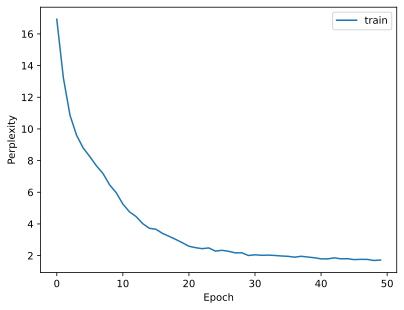

In [500]:
num_epochs, lr = 500, 5e-4
device = "cuda:0"
loss = nn.CrossEntropyLoss()

# 初始化网络
rnn = RNN(len(vocab), num_hiddens, device, get_rnn_params, init_rnn_state, rnn_forward)
# 定义优化器
opt = torch.optim.Adam(rnn.parameters(), lr=lr)
# 文本生成函数
pred_fn = lambda prefix: predict(prefix, 50, rnn, vocab, device)

rnn.train()
ppl_ = []

for epo in tqdm(range(num_epochs)):
    ppl, speed = train_rnn_one_epoch(
        rnn, train_iter, loss, opt, device, False)
    if (epo + 1) % 10 == 0:
        # print(f"epo:{epo+1}\t ppl:{ppl:.1f}\t")
        # print(pred_fn("time traveller"))
        ppl_.append(float(ppl))

print(f'困惑度[{ppl:.1f}], 速度[{speed:.1f} 词元/秒], 设备[{str(device)}]')
print(pred_fn('time traveller'))
print(pred_fn('traveller'))

plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.plot(ppl_)
plt.legend(["train"])